In [ ]:
import json, torch, torch.nn as nn, numpy as np, pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("train-claims.json") as f:
    train_claims = json.load(f)
with open("dev-claims.json") as f:
    dev_claims = json.load(f)
with open("evidence.json") as f:
    evidence_data = json.load(f)

def claims_to_df(claims_dict):
    data = []
    for cid, v in claims_dict.items():
        ev_texts = [evidence_data[eid] for eid in v["evidences"] if eid in evidence_data]
        data.append({
            "claim_id": cid,
            "claim_text": v["claim_text"],
            "evidence_text": " ".join(ev_texts),
            "label": v["claim_label"]
        })
    return pd.DataFrame(data)

train_df = claims_to_df(train_claims)
dev_df = claims_to_df(dev_claims)
df = pd.concat([train_df, dev_df]).dropna()

label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

# Load pretrained gloVe
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

def load_glove(path, tokenizer, dim=100):
    embeddings = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word, vec = values[0], np.asarray(values[1:], dtype="float32")
            embeddings[word] = vec
    vocab_size = tokenizer.vocab_size
    embed_matrix = np.zeros((vocab_size, dim))
    for word, idx in tokenizer.get_vocab().items():
        if word in embeddings:
            embed_matrix[idx] = embeddings[word]
    return torch.tensor(embed_matrix, dtype=torch.float)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
glove_tensor = load_glove("glove.6B.100d.txt", tokenizer, dim=100)

# Dataset class
class ClaimDataset(Dataset):
    def __init__(self, claims, evidences, labels, tokenizer, max_len=128):
        self.claims = claims
        self.evidences = evidences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        text = self.claims[idx] + " " + self.evidences[idx]
        enc = self.tokenizer(text, truncation=True, padding='max_length',
                             max_length=self.max_len, return_tensors='pt')
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

dev_df["label_id"] = label_encoder.transform(dev_df["label"])
train_df["label_id"] = label_encoder.transform(train_df["label"])
train_dataset = ClaimDataset(train_df["claim_text"].tolist(), train_df["evidence_text"].tolist(), train_df["label_id"].tolist(), tokenizer)
dev_dataset = ClaimDataset(dev_df["claim_text"].tolist(), dev_df["evidence_text"].tolist(), dev_df["label_id"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)

# Calculate the class weights
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label_id"]),
    y=df["label_id"]
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, glove_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_matrix, freeze=False, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)
        x = self.dropout(self.layernorm(x))
        return self.fc(x)

model = GRUClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=100,
    hidden_dim=64,
    num_classes=len(label_encoder.classes_),
    pad_idx=tokenizer.pad_token_id,
    glove_matrix=glove_tensor
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Training
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation
from sklearn.metrics import classification_report
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Training + Evaluation
for epoch in range(20):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")

print("Evaluation on dev-claims.json:")
evaluate(model, dev_loader)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1 Loss: 1.4380
Epoch 2 Loss: 1.3778
Epoch 3 Loss: 1.2980
Epoch 4 Loss: 1.2806
Epoch 5 Loss: 1.2495
Epoch 6 Loss: 1.2221
Epoch 7 Loss: 1.1776
Epoch 8 Loss: 1.1362
Epoch 9 Loss: 1.1155
Epoch 10 Loss: 1.0582
Epoch 11 Loss: 1.0144
Epoch 12 Loss: 0.9521
Epoch 13 Loss: 0.9068
Epoch 14 Loss: 0.8572
Epoch 15 Loss: 0.7946
Epoch 16 Loss: 0.7177
Epoch 17 Loss: 0.6595
Epoch 18 Loss: 0.6004
Epoch 19 Loss: 0.5405
Epoch 20 Loss: 0.4461
Evaluation on dev-claims.json:
                 precision    recall  f1-score   support

       DISPUTED       0.18      0.22      0.20        18
NOT_ENOUGH_INFO       0.63      0.46      0.54        41
        REFUTES       0.33      0.44      0.38        27
       SUPPORTS       0.58      0.56      0.57        68

       accuracy                           0.47       154
      macro avg       0.43      0.42      0.42       154
   weighted avg       0.50      0.47      0.48       154



In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, gru_output, mask=None):
        weights = self.attn(gru_output).squeeze(-1)
        if mask is not None:
            weights = weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(weights, dim=1).unsqueeze(-1)
        context = torch.sum(gru_output * attn_weights, dim=1)
        return context

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, glove_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_matrix, freeze=False, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_dim)
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        output, _ = self.gru(x)
        context = self.attn(output, attention_mask)
        context = self.dropout(self.layernorm(context))
        return self.fc(context)


In [ ]:
def claims_to_df(claims_dict):
    data = []
    for cid, v in claims_dict.items():
        ev_texts = [evidence_data[eid] for eid in v["evidences"] if eid in evidence_data]
        data.append({
            "claim_id": cid,
            "claim_text": v["claim_text"],
            "evidence_text": " ".join(ev_texts),
            "label": v["claim_label"]
        })
    return pd.DataFrame(data)

train_df = claims_to_df(train_claims)
dev_df = claims_to_df(dev_claims)
df = pd.concat([train_df, dev_df]).dropna()

label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

def load_glove(path, tokenizer, dim=100):
    embeddings = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word, vec = values[0], np.asarray(values[1:], dtype="float32")
            embeddings[word] = vec
    vocab_size = tokenizer.vocab_size
    embed_matrix = np.zeros((vocab_size, dim))
    for word, idx in tokenizer.get_vocab().items():
        if word in embeddings:
            embed_matrix[idx] = embeddings[word]
    return torch.tensor(embed_matrix, dtype=torch.float)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
glove_tensor = load_glove("glove.6B.100d.txt", tokenizer, dim=100)

class ClaimDataset(Dataset):
    def __init__(self, claims, evidences, labels, tokenizer, max_len=128):
        self.claims = claims
        self.evidences = evidences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        text = self.claims[idx] + " " + self.evidences[idx]
        enc = self.tokenizer(text, truncation=True, padding='max_length',
                             max_length=self.max_len, return_tensors='pt')
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

dev_df["label_id"] = label_encoder.transform(dev_df["label"])
train_df["label_id"] = label_encoder.transform(train_df["label"])
train_dataset = ClaimDataset(train_df["claim_text"].tolist(), train_df["evidence_text"].tolist(), train_df["label_id"].tolist(), tokenizer)
dev_dataset = ClaimDataset(dev_df["claim_text"].tolist(), dev_df["evidence_text"].tolist(), dev_df["label_id"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)

# Add class weights
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label_id"]),
    y=df["label_id"]
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, gru_output, mask=None):
        weights = self.attn(gru_output).squeeze(-1)
        if mask is not None:
            weights = weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(weights, dim=1).unsqueeze(-1)
        context = torch.sum(gru_output * attn_weights, dim=1)
        return context

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, glove_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_matrix, freeze=False, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_dim)
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        output, _ = self.gru(x)
        context = self.attn(output, attention_mask)  # attention pooling
        context = self.dropout(self.layernorm(context))
        return self.fc(context)

model1 = GRUClassifierWithAttention(
    vocab_size=tokenizer.vocab_size,
    embed_dim=100,
    hidden_dim=64,
    num_classes=len(label_encoder.classes_),
    pad_idx=tokenizer.pad_token_id,
    glove_matrix=glove_tensor
).to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Training
def train_epoch(model1, loader):
    model1.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model1(input_ids)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation
from sklearn.metrics import classification_report
def evaluate(model1, loader):
    model1.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model1(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Training + Evaluation
for epoch in range(15):
    loss = train_epoch(model1, train_loader)
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")

print("Evaluation on dev-claims.json:")
evaluate(model1, dev_loader)

Epoch 1 Loss: 1.3884
Epoch 2 Loss: 1.3066
Epoch 3 Loss: 1.2588
Epoch 4 Loss: 1.2442
Epoch 5 Loss: 1.2084
Epoch 6 Loss: 1.1862
Epoch 7 Loss: 1.1470
Epoch 8 Loss: 1.1347
Epoch 9 Loss: 1.1227
Epoch 10 Loss: 1.0626
Epoch 11 Loss: 1.0151
Epoch 12 Loss: 0.9796
Epoch 13 Loss: 0.9526
Epoch 14 Loss: 0.8778
Epoch 15 Loss: 0.8322
Evaluation on dev-claims.json:
                 precision    recall  f1-score   support

       DISPUTED       0.05      0.06      0.05        18
NOT_ENOUGH_INFO       0.56      0.46      0.51        41
        REFUTES       0.38      0.56      0.45        27
       SUPPORTS       0.59      0.51      0.55        68

       accuracy                           0.45       154
      macro avg       0.39      0.40      0.39       154
   weighted avg       0.48      0.45      0.46       154



In [ ]:
from sentence_transformers import SentenceTransformer, util
sbert = SentenceTransformer("all-MiniLM-L6-v2")

def rank_and_filter_evidence(claims_dict, evidence_dict, top_k=5):
    records = []
    for cid, entry in claims_dict.items():
        claim = entry["claim_text"]
        label = entry.get("claim_label") 
        evid_ids = [eid for eid in entry["evidences"] if eid in evidence_dict]
        evid_texts = [evidence_dict[eid] for eid in evid_ids]

        if not evid_texts:
            continue

        # SBERT similarity
        claim_emb = sbert.encode(claim, convert_to_tensor=True)
        evid_embs = sbert.encode(evid_texts, convert_to_tensor=True)
        sims = util.cos_sim(claim_emb, evid_embs).squeeze(0)
        top_indices = sims.argsort(descending=True)[:top_k]

        # Join top evidence
        top_evidence = " ".join([evid_texts[i] for i in top_indices])

        records.append({
            "claim_id": cid,
            "claim_text": claim,
            "evidence_text": top_evidence,
            "label": label
        })

    return pd.DataFrame(records)

filtered_train_df = rank_and_filter_evidence(train_claims, evidence_data, top_k=2)
filtered_dev_df = rank_and_filter_evidence(dev_claims, evidence_data, top_k=2)

filtered_train_df = filtered_train_df.dropna()
filtered_dev_df = filtered_dev_df.dropna()
filtered_train_df['label_id'] = label_encoder.transform(filtered_train_df['label'])
filtered_dev_df['label_id'] = label_encoder.transform(filtered_dev_df['label'])

train_dataset = ClaimDataset(filtered_train_df["claim_text"].tolist(),
                             filtered_train_df["evidence_text"].tolist(),
                             filtered_train_df["label_id"].tolist(), tokenizer)

dev_dataset = ClaimDataset(filtered_dev_df["claim_text"].tolist(),
                           filtered_dev_df["evidence_text"].tolist(),
                           filtered_dev_df["label_id"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)

# Add class Weights
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label_id"]),
    y=df["label_id"]
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, gru_output, mask=None):
        weights = self.attn(gru_output).squeeze(-1)
        if mask is not None:
            weights = weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(weights, dim=1).unsqueeze(-1)
        context = torch.sum(gru_output * attn_weights, dim=1)
        return context

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, glove_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_matrix, freeze=False, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_dim)
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        output, _ = self.gru(x)
        context = self.attn(output, attention_mask)  # attention pooling
        context = self.dropout(self.layernorm(context))
        return self.fc(context)

model2 = GRUClassifierWithAttention(
    vocab_size=tokenizer.vocab_size,
    embed_dim=100,
    hidden_dim=64,
    num_classes=len(label_encoder.classes_),
    pad_idx=tokenizer.pad_token_id,
    glove_matrix=glove_tensor
).to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Training
def train_epoch(model2, loader):
    model2.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model2(input_ids)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation
from sklearn.metrics import classification_report
def evaluate(model2, loader):
    model2.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model2(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    used_class_ids = sorted(set(all_preds) | set(all_labels))
    target_names = [label_encoder.classes_[i] for i in used_class_ids]
    print(classification_report(all_labels, all_preds, labels=used_class_ids, target_names=target_names))

# Training + Evaluation
for epoch in range(15):
    loss = train_epoch(model2, train_loader)
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")

print("Evaluation on dev-claims.json:")
evaluate(model2, dev_loader)

Epoch 1 Loss: 1.5025
Epoch 2 Loss: 1.5080
Epoch 3 Loss: 1.4743
Epoch 4 Loss: 1.5062
Epoch 5 Loss: 1.5090
Epoch 6 Loss: 1.5237
Epoch 7 Loss: 1.5050
Epoch 8 Loss: 1.4999
Epoch 9 Loss: 1.4957
Epoch 10 Loss: 1.4926
Epoch 11 Loss: 1.5059
Epoch 12 Loss: 1.4970
Epoch 13 Loss: 1.5179
Epoch 14 Loss: 1.5065
Epoch 15 Loss: 1.5216
Evaluation on dev-claims.json:
                 precision    recall  f1-score   support

       DISPUTED       0.11      0.28      0.16        18
NOT_ENOUGH_INFO       0.00      0.00      0.00        41
        REFUTES       0.00      0.00      0.00        27
       SUPPORTS       0.44      0.71      0.55        68

       accuracy                           0.34       154
      macro avg       0.14      0.25      0.18       154
   weighted avg       0.21      0.34      0.26       154



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Eveluation:

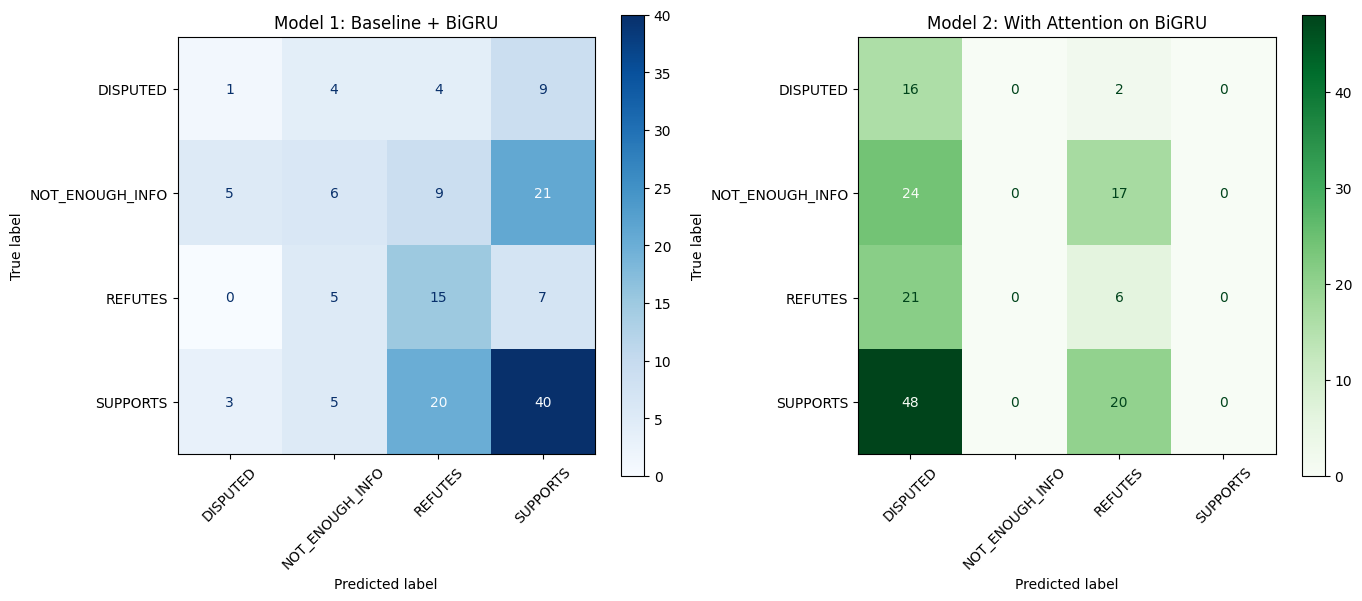

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Get labels and predictions
y_true_0, y_pred_0 = get_predictions_and_labels(model, dev_loader)
y_true_1, y_pred_1 = get_predictions_and_labels(model1, dev_loader)
y_true_2, y_pred_2 = get_predictions_and_labels(model2, dev_loader)

y_pred_model = [label_encoder.classes_[i] for i in y_pred_0]
y_pred_model1 = [label_encoder.classes_[i] for i in y_pred_1]
y_pred_model2 = [label_encoder.classes_[i] for i in y_pred_2]

# Confusion matrix
class_names = label_encoder.classes_

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

cm1 = confusion_matrix(y_true_1, y_pred_1)
ConfusionMatrixDisplay(cm1, display_labels=class_names).plot(ax=axs[0], cmap='Blues', xticks_rotation=45)
axs[0].set_title("Model 1: Baseline + BiGRU")

cm2 = confusion_matrix(y_true_2, y_pred_2)
ConfusionMatrixDisplay(cm2, display_labels=class_names).plot(ax=axs[1], cmap='Greens', xticks_rotation=45)
axs[1].set_title("Model 2: With Attention on BiGRU")

plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import display
import textwrap

def wrap_text(text, width=80):
    return '\n'.join(textwrap.wrap(text, width=width))

error_data = []

for i, cid in enumerate(claim_ids):
    true_label = y_true_dev[i]
    claim_text = dev_claims[cid]["claim_text"]
    evidences = dev_claims[cid].get("evidences", [])
    formatted_evidence = ", ".join(evidences)

    for model_name, preds in [('Baseline Model', y_pred_model),
                              ('Model 1: Baseline + BiGRU', y_pred_model1),
                              ('Model 1 + Attention on BiGRU', y_pred_model2)]:

        pred_label = preds[i]
        if pred_label != true_label:
            error_data.append({
                "Model": model_name,
                "Claim ID": cid,
                "Claim Text": wrap_text(claim_text, width=80),
                "True Label": true_label,
                "Predicted Label": pred_label,
                "Evidence IDs": wrap_text(formatted_evidence, width=60)
            })

df_errors = pd.DataFrame(error_data)

pd.set_option('display.max_colwidth', None)
display(df_errors.head(10))

# Save
df_errors.to_csv("error_analysis_table.csv", index=False)

,Model,Claim ID,Claim Text,True Label,Predicted Label,Evidence IDs
0,Baseline Model,claim-752,[South Australia] has the most expensive electricity in the world.,SUPPORTS,REFUTES,"evidence-67732, evidence-572512"
1,Model 1: Baseline + BiGRU,claim-752,[South Australia] has the most expensive electricity in the world.,SUPPORTS,REFUTES,"evidence-67732, evidence-572512"
2,Model 1 + Attention on BiGRU,claim-752,[South Australia] has the most expensive electricity in the world.,SUPPORTS,DISPUTED,"evidence-67732, evidence-572512"
3,Baseline Model,claim-375,"when 3 per cent of total annual global emissions of carbon dioxide are from\nhumans and Australia prod­uces 1.3 per cent of this 3 per cent, then no amount\nof emissions reductio­n here will have any effect on global climate.",NOT_ENOUGH_INFO,SUPPORTS,"evidence-996421, evidence-1080858, evidence-208053,\nevidence-699212, evidence-832334"
4,Model 1: Baseline + BiGRU,claim-375,"when 3 per cent of total annual global emissions of carbon dioxide are from\nhumans and Australia prod­uces 1.3 per cent of this 3 per cent, then no amount\nof emissions reductio­n here will have any effect on global climate.",NOT_ENOUGH_INFO,REFUTES,"evidence-996421, evidence-1080858, evidence-208053,\nevidence-699212, evidence-832334"
5,Model 1 + Attention on BiGRU,claim-375,"when 3 per cent of total annual global emissions of carbon dioxide are from\nhumans and Australia prod­uces 1.3 per cent of this 3 per cent, then no amount\nof emissions reductio­n here will have any effect on global climate.",NOT_ENOUGH_INFO,REFUTES,"evidence-996421, evidence-1080858, evidence-208053,\nevidence-699212, evidence-832334"
6,Baseline Model,claim-1266,This means that the world is now 1C warmer than it was in pre-industrial times,SUPPORTS,REFUTES,"evidence-889933, evidence-694262"
7,Model 1: Baseline + BiGRU,claim-1266,This means that the world is now 1C warmer than it was in pre-industrial times,SUPPORTS,REFUTES,"evidence-889933, evidence-694262"
8,Model 1 + Attention on BiGRU,claim-1266,This means that the world is now 1C warmer than it was in pre-industrial times,SUPPORTS,DISPUTED,"evidence-889933, evidence-694262"
9,Baseline Model,claim-871,"“As it happens, Zika may also be a good model of the second worrying effect —\ndisease mutation.",NOT_ENOUGH_INFO,SUPPORTS,"evidence-422399, evidence-702226, evidence-286834,\nevidence-472751, evidence-641043"


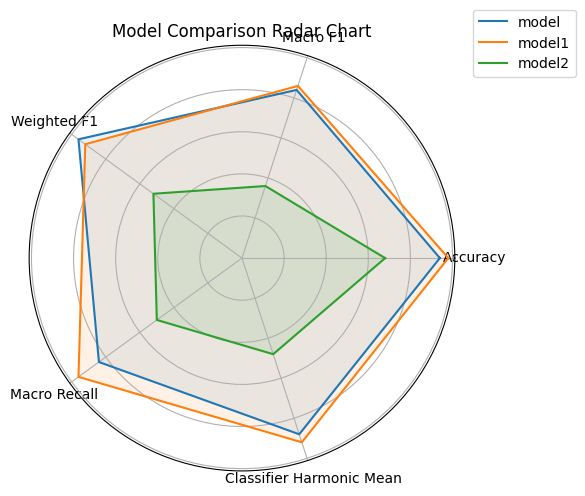

In [ ]:
metrics = ['Accuracy', 'Macro F1', 'Weighted F1', 'Macro Recall', 'Classifier Harmonic Mean']
scores = {
    'model': [0.47, 0.42, 0.48, 0.42, 0.44],
    'model1': [0.49, 0.43, 0.46, 0.48, 0.46],
    'model2': [0.34, 0.18, 0.26, 0.25, 0.24],
}

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
metrics += metrics[:1]
angles += angles[:1]

def add_model_radar(ax, values, label):
    values = values + values[:1]  # close loop
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.1)

# Radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
add_model_radar(ax, scores['model'], 'model')
add_model_radar(ax, scores['model1'], 'model1')
add_model_radar(ax, scores['model2'], 'model2')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics[:-1])
ax.set_yticklabels([])
plt.title('Model Comparison Radar Chart')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
